# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

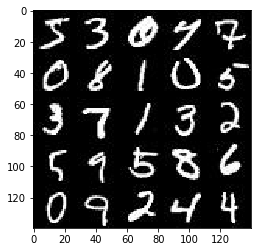

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

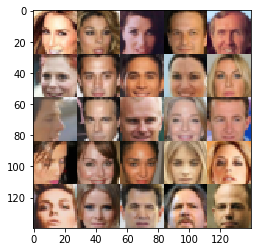

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.5.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 32, 5, 2, padding='same')
        x1 = tf.nn.leaky_relu(x1)
        # 14x14x32
        
        h1 = tf.layers.conv2d(x1, 64, 5, 2, padding='same')
        h1 = tf.layers.batch_normalization(h1, training=True)
        h1 = tf.nn.leaky_relu(h1)
        # 7x7x64
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.nn.leaky_relu(h2)
        # 4x4x128
        
        flattened = tf.reshape(h2, (-1, 4*4*128))
        logits = tf.layers.dense(flattened, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 2*2*512)
        x = tf.reshape(x, (-1, 2, 2, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.leaky_relu(x)
        # 4x4x512
        
        h1 = tf.layers.conv2d_transpose(x, 512, 5, 2, padding='valid')
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.nn.leaky_relu(h1)
        # 7x7x512
        
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.nn.leaky_relu(h2)
        # 16x16x256
        
        # 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(h2, out_channel_dim, 5, 2, padding='same')        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    d_vars = tf.trainable_variables('discriminator')
    g_vars = tf.trainable_variables('generator')
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
import matplotlib.pyplot as plt

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    output_channel_dim = 3 if data_image_mode == "RGB" else 1
    losses, samples = [], []
    
    _real_input, _z_input, _learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(_real_input, _z_input, output_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, _learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        train_count = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_train_opt, feed_dict={_z_input: batch_z, 
                                                 _real_input: batch_images,
                                                 _learning_rate: learning_rate})
                sess.run(g_train_opt, feed_dict={_z_input: batch_z, 
                                                 _real_input: batch_images,
                                                 _learning_rate: learning_rate})
                
                train_count += 1
                
                train_loss_d = d_loss.eval({_real_input: batch_images, _z_input: batch_z})
                train_loss_g = g_loss.eval({_z_input: batch_z})
                
                losses.append((train_loss_d, train_loss_g))
                
                if train_count % 10 == 0:
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if train_count % 100 == 0:
                    show_generator_output(sess, 25, _z_input, output_channel_dim, data_image_mode)
                
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.0371... Generator Loss: 0.2422
Epoch 1/2... Discriminator Loss: 0.5089... Generator Loss: 1.2166
Epoch 1/2... Discriminator Loss: 0.4557... Generator Loss: 1.2573
Epoch 1/2... Discriminator Loss: 0.2609... Generator Loss: 1.8296
Epoch 1/2... Discriminator Loss: 0.3054... Generator Loss: 1.9521
Epoch 1/2... Discriminator Loss: 0.3610... Generator Loss: 1.7254
Epoch 1/2... Discriminator Loss: 0.6839... Generator Loss: 1.0499
Epoch 1/2... Discriminator Loss: 0.1935... Generator Loss: 2.7320
Epoch 1/2... Discriminator Loss: 0.4077... Generator Loss: 1.6147
Epoch 1/2... Discriminator Loss: 0.3365... Generator Loss: 2.2017


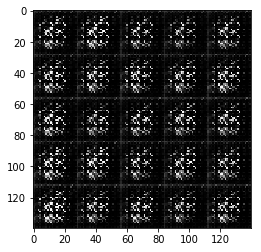

Epoch 1/2... Discriminator Loss: 0.1835... Generator Loss: 2.3834
Epoch 1/2... Discriminator Loss: 0.5937... Generator Loss: 1.8556
Epoch 1/2... Discriminator Loss: 0.4349... Generator Loss: 1.9040
Epoch 1/2... Discriminator Loss: 0.1582... Generator Loss: 2.8713
Epoch 1/2... Discriminator Loss: 0.2994... Generator Loss: 2.2332
Epoch 1/2... Discriminator Loss: 0.5303... Generator Loss: 1.4029
Epoch 1/2... Discriminator Loss: 1.0406... Generator Loss: 0.7235
Epoch 1/2... Discriminator Loss: 0.3984... Generator Loss: 1.9177
Epoch 1/2... Discriminator Loss: 0.1923... Generator Loss: 2.0437
Epoch 1/2... Discriminator Loss: 0.1953... Generator Loss: 2.8204


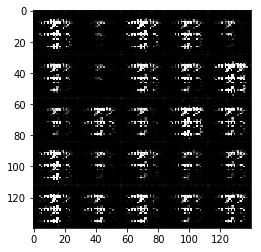

Epoch 1/2... Discriminator Loss: 0.0838... Generator Loss: 3.5819
Epoch 1/2... Discriminator Loss: 0.0754... Generator Loss: 3.5374
Epoch 1/2... Discriminator Loss: 0.1106... Generator Loss: 3.0074
Epoch 1/2... Discriminator Loss: 0.4667... Generator Loss: 1.3675
Epoch 1/2... Discriminator Loss: 0.3000... Generator Loss: 2.9241
Epoch 1/2... Discriminator Loss: 0.1145... Generator Loss: 3.4824
Epoch 1/2... Discriminator Loss: 0.0326... Generator Loss: 4.7143
Epoch 1/2... Discriminator Loss: 0.0235... Generator Loss: 4.8711
Epoch 1/2... Discriminator Loss: 0.0595... Generator Loss: 3.4029
Epoch 1/2... Discriminator Loss: 0.5673... Generator Loss: 1.9799


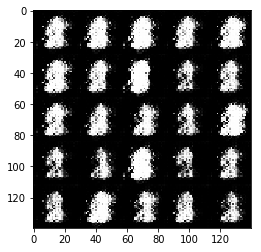

Epoch 1/2... Discriminator Loss: 0.2568... Generator Loss: 2.1599
Epoch 1/2... Discriminator Loss: 0.0861... Generator Loss: 3.1514
Epoch 1/2... Discriminator Loss: 0.1021... Generator Loss: 3.1490
Epoch 1/2... Discriminator Loss: 0.1968... Generator Loss: 2.5098
Epoch 1/2... Discriminator Loss: 0.4808... Generator Loss: 1.9384
Epoch 1/2... Discriminator Loss: 0.2854... Generator Loss: 3.8070
Epoch 1/2... Discriminator Loss: 0.2098... Generator Loss: 3.0760
Epoch 1/2... Discriminator Loss: 0.5401... Generator Loss: 1.3477
Epoch 1/2... Discriminator Loss: 0.7294... Generator Loss: 4.4852
Epoch 1/2... Discriminator Loss: 0.2439... Generator Loss: 2.0824


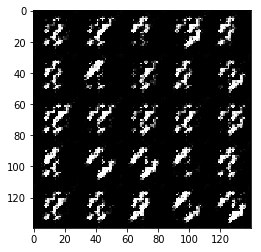

Epoch 1/2... Discriminator Loss: 0.6055... Generator Loss: 1.2700
Epoch 1/2... Discriminator Loss: 0.4486... Generator Loss: 1.7574
Epoch 1/2... Discriminator Loss: 0.9263... Generator Loss: 0.9439
Epoch 1/2... Discriminator Loss: 0.2823... Generator Loss: 1.9433
Epoch 1/2... Discriminator Loss: 0.3949... Generator Loss: 1.8812
Epoch 1/2... Discriminator Loss: 0.4283... Generator Loss: 1.7551
Epoch 1/2... Discriminator Loss: 0.1922... Generator Loss: 2.6651
Epoch 1/2... Discriminator Loss: 0.3394... Generator Loss: 1.8525
Epoch 1/2... Discriminator Loss: 0.2904... Generator Loss: 3.7133
Epoch 1/2... Discriminator Loss: 0.2964... Generator Loss: 2.3649


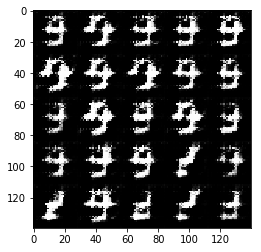

Epoch 1/2... Discriminator Loss: 0.3888... Generator Loss: 2.1222
Epoch 1/2... Discriminator Loss: 0.2257... Generator Loss: 2.6949
Epoch 1/2... Discriminator Loss: 0.2244... Generator Loss: 2.4050
Epoch 1/2... Discriminator Loss: 0.6427... Generator Loss: 1.4965
Epoch 1/2... Discriminator Loss: 0.2010... Generator Loss: 2.1921
Epoch 1/2... Discriminator Loss: 0.5765... Generator Loss: 1.3013
Epoch 1/2... Discriminator Loss: 0.3618... Generator Loss: 1.6519
Epoch 1/2... Discriminator Loss: 0.2058... Generator Loss: 4.0997
Epoch 1/2... Discriminator Loss: 0.5211... Generator Loss: 1.8331
Epoch 1/2... Discriminator Loss: 0.4498... Generator Loss: 1.7130


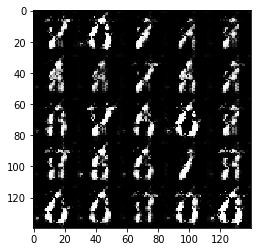

Epoch 1/2... Discriminator Loss: 0.3599... Generator Loss: 1.7316
Epoch 1/2... Discriminator Loss: 0.3507... Generator Loss: 2.3185
Epoch 1/2... Discriminator Loss: 0.5867... Generator Loss: 1.6134
Epoch 1/2... Discriminator Loss: 0.1917... Generator Loss: 3.0804
Epoch 1/2... Discriminator Loss: 0.3838... Generator Loss: 2.9693
Epoch 1/2... Discriminator Loss: 0.3338... Generator Loss: 2.0746
Epoch 1/2... Discriminator Loss: 1.9854... Generator Loss: 5.4911
Epoch 1/2... Discriminator Loss: 0.5577... Generator Loss: 1.0947
Epoch 1/2... Discriminator Loss: 0.3550... Generator Loss: 2.2469
Epoch 1/2... Discriminator Loss: 0.5500... Generator Loss: 1.5282


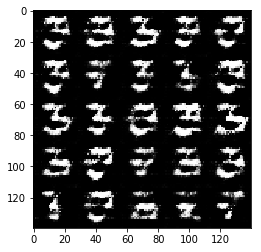

Epoch 1/2... Discriminator Loss: 0.3864... Generator Loss: 1.9794
Epoch 1/2... Discriminator Loss: 0.5167... Generator Loss: 1.4501
Epoch 1/2... Discriminator Loss: 0.7104... Generator Loss: 1.2444
Epoch 1/2... Discriminator Loss: 0.5797... Generator Loss: 1.7207
Epoch 1/2... Discriminator Loss: 0.4627... Generator Loss: 1.9812
Epoch 1/2... Discriminator Loss: 0.3123... Generator Loss: 2.3232
Epoch 1/2... Discriminator Loss: 0.9455... Generator Loss: 2.1247
Epoch 1/2... Discriminator Loss: 0.6811... Generator Loss: 1.6194
Epoch 1/2... Discriminator Loss: 0.6176... Generator Loss: 1.3694
Epoch 1/2... Discriminator Loss: 1.2078... Generator Loss: 0.5922


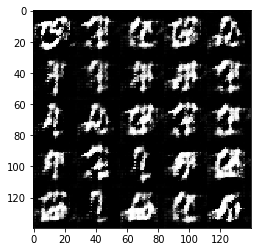

Epoch 1/2... Discriminator Loss: 0.5217... Generator Loss: 1.5635
Epoch 1/2... Discriminator Loss: 0.5439... Generator Loss: 1.9806
Epoch 1/2... Discriminator Loss: 0.7672... Generator Loss: 1.0541
Epoch 1/2... Discriminator Loss: 0.2499... Generator Loss: 2.8068
Epoch 1/2... Discriminator Loss: 0.6404... Generator Loss: 1.6296
Epoch 1/2... Discriminator Loss: 0.4242... Generator Loss: 1.9916
Epoch 1/2... Discriminator Loss: 0.7295... Generator Loss: 1.2503
Epoch 1/2... Discriminator Loss: 0.8781... Generator Loss: 1.3091
Epoch 1/2... Discriminator Loss: 0.5459... Generator Loss: 2.0492
Epoch 1/2... Discriminator Loss: 0.5962... Generator Loss: 1.6808


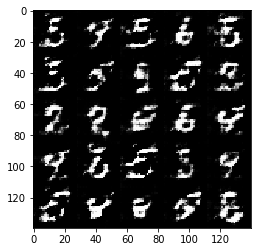

Epoch 1/2... Discriminator Loss: 1.0258... Generator Loss: 3.2532
Epoch 1/2... Discriminator Loss: 0.3166... Generator Loss: 2.1713
Epoch 1/2... Discriminator Loss: 0.6030... Generator Loss: 1.8210
Epoch 1/2... Discriminator Loss: 0.7922... Generator Loss: 0.8318
Epoch 1/2... Discriminator Loss: 0.4655... Generator Loss: 1.8603
Epoch 1/2... Discriminator Loss: 0.4524... Generator Loss: 2.5196
Epoch 1/2... Discriminator Loss: 0.6683... Generator Loss: 1.3396
Epoch 1/2... Discriminator Loss: 0.6006... Generator Loss: 3.1503
Epoch 1/2... Discriminator Loss: 0.8825... Generator Loss: 1.1091
Epoch 1/2... Discriminator Loss: 0.7094... Generator Loss: 0.9566


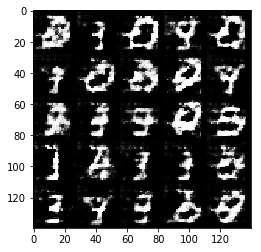

Epoch 1/2... Discriminator Loss: 0.8228... Generator Loss: 1.1522
Epoch 1/2... Discriminator Loss: 0.9102... Generator Loss: 2.6783
Epoch 1/2... Discriminator Loss: 0.6276... Generator Loss: 1.7282
Epoch 1/2... Discriminator Loss: 0.5250... Generator Loss: 1.7657
Epoch 1/2... Discriminator Loss: 1.0584... Generator Loss: 0.9571
Epoch 1/2... Discriminator Loss: 0.6132... Generator Loss: 1.5640
Epoch 1/2... Discriminator Loss: 0.9657... Generator Loss: 1.2608
Epoch 1/2... Discriminator Loss: 0.4326... Generator Loss: 1.7310
Epoch 1/2... Discriminator Loss: 0.6113... Generator Loss: 1.3494
Epoch 1/2... Discriminator Loss: 0.7241... Generator Loss: 1.4114


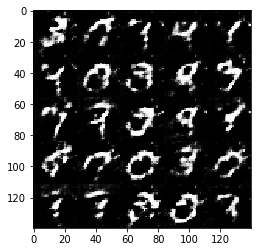

Epoch 1/2... Discriminator Loss: 0.9690... Generator Loss: 0.8759
Epoch 1/2... Discriminator Loss: 1.1407... Generator Loss: 1.9929
Epoch 1/2... Discriminator Loss: 0.9885... Generator Loss: 0.8833
Epoch 1/2... Discriminator Loss: 0.7479... Generator Loss: 1.3467
Epoch 1/2... Discriminator Loss: 0.7120... Generator Loss: 1.4780
Epoch 1/2... Discriminator Loss: 0.7364... Generator Loss: 1.5924
Epoch 1/2... Discriminator Loss: 0.8015... Generator Loss: 1.0300
Epoch 1/2... Discriminator Loss: 0.9002... Generator Loss: 0.8557
Epoch 1/2... Discriminator Loss: 0.8156... Generator Loss: 1.0306
Epoch 1/2... Discriminator Loss: 1.0372... Generator Loss: 1.1670


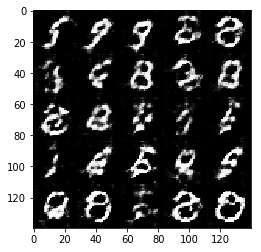

Epoch 1/2... Discriminator Loss: 0.9149... Generator Loss: 0.7393
Epoch 1/2... Discriminator Loss: 0.7044... Generator Loss: 1.4085
Epoch 1/2... Discriminator Loss: 1.0627... Generator Loss: 0.6429
Epoch 1/2... Discriminator Loss: 0.8613... Generator Loss: 0.9537
Epoch 1/2... Discriminator Loss: 1.1012... Generator Loss: 2.1592
Epoch 1/2... Discriminator Loss: 0.8214... Generator Loss: 1.4381
Epoch 1/2... Discriminator Loss: 0.8704... Generator Loss: 0.8820
Epoch 1/2... Discriminator Loss: 0.7322... Generator Loss: 1.2429
Epoch 1/2... Discriminator Loss: 1.1142... Generator Loss: 0.9761
Epoch 1/2... Discriminator Loss: 0.8163... Generator Loss: 1.0903


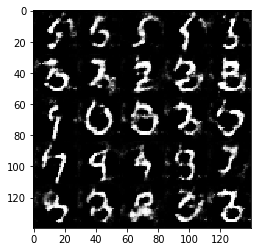

Epoch 1/2... Discriminator Loss: 0.7749... Generator Loss: 1.5817
Epoch 1/2... Discriminator Loss: 0.8313... Generator Loss: 1.3047
Epoch 1/2... Discriminator Loss: 0.8875... Generator Loss: 1.0737
Epoch 1/2... Discriminator Loss: 0.6329... Generator Loss: 1.8330
Epoch 1/2... Discriminator Loss: 0.8804... Generator Loss: 1.0768
Epoch 1/2... Discriminator Loss: 1.1813... Generator Loss: 0.7278
Epoch 1/2... Discriminator Loss: 0.5773... Generator Loss: 1.5533
Epoch 1/2... Discriminator Loss: 0.9519... Generator Loss: 1.9765
Epoch 1/2... Discriminator Loss: 0.7511... Generator Loss: 1.6974
Epoch 1/2... Discriminator Loss: 1.1981... Generator Loss: 0.4727


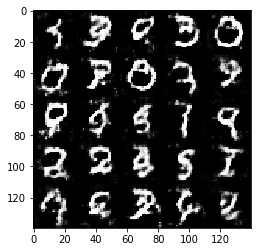

Epoch 1/2... Discriminator Loss: 1.0104... Generator Loss: 0.6203
Epoch 1/2... Discriminator Loss: 1.4121... Generator Loss: 0.4921
Epoch 1/2... Discriminator Loss: 0.9568... Generator Loss: 2.0913
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 0.9329
Epoch 1/2... Discriminator Loss: 0.9343... Generator Loss: 0.8049
Epoch 1/2... Discriminator Loss: 1.2728... Generator Loss: 0.5176
Epoch 1/2... Discriminator Loss: 1.5735... Generator Loss: 0.3698
Epoch 1/2... Discriminator Loss: 0.7249... Generator Loss: 1.0918
Epoch 1/2... Discriminator Loss: 1.0827... Generator Loss: 0.8154
Epoch 1/2... Discriminator Loss: 0.9733... Generator Loss: 0.6646


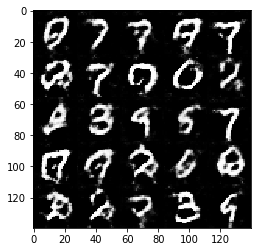

Epoch 1/2... Discriminator Loss: 0.9014... Generator Loss: 1.1490
Epoch 1/2... Discriminator Loss: 0.8359... Generator Loss: 1.2686
Epoch 1/2... Discriminator Loss: 0.9134... Generator Loss: 0.7719
Epoch 1/2... Discriminator Loss: 1.0352... Generator Loss: 1.6906
Epoch 1/2... Discriminator Loss: 1.2568... Generator Loss: 0.9792
Epoch 1/2... Discriminator Loss: 1.2208... Generator Loss: 0.6235
Epoch 1/2... Discriminator Loss: 1.1708... Generator Loss: 1.6803
Epoch 1/2... Discriminator Loss: 1.1674... Generator Loss: 0.6217
Epoch 1/2... Discriminator Loss: 0.8992... Generator Loss: 1.5260
Epoch 1/2... Discriminator Loss: 1.2350... Generator Loss: 0.6120


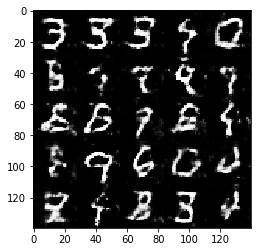

Epoch 1/2... Discriminator Loss: 0.9169... Generator Loss: 0.9239
Epoch 1/2... Discriminator Loss: 0.9698... Generator Loss: 0.8021
Epoch 1/2... Discriminator Loss: 0.9969... Generator Loss: 1.2106
Epoch 1/2... Discriminator Loss: 1.0316... Generator Loss: 0.7372
Epoch 1/2... Discriminator Loss: 0.6996... Generator Loss: 1.2049
Epoch 1/2... Discriminator Loss: 1.1478... Generator Loss: 0.5822
Epoch 1/2... Discriminator Loss: 1.1864... Generator Loss: 0.5900
Epoch 1/2... Discriminator Loss: 0.7078... Generator Loss: 1.1941
Epoch 1/2... Discriminator Loss: 1.4400... Generator Loss: 0.4346
Epoch 1/2... Discriminator Loss: 0.8504... Generator Loss: 0.9404


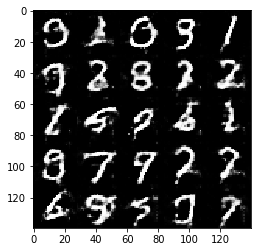

Epoch 1/2... Discriminator Loss: 1.0485... Generator Loss: 1.3812
Epoch 1/2... Discriminator Loss: 1.3388... Generator Loss: 0.8409
Epoch 1/2... Discriminator Loss: 1.5416... Generator Loss: 0.4096
Epoch 1/2... Discriminator Loss: 0.9505... Generator Loss: 1.3242
Epoch 1/2... Discriminator Loss: 0.6934... Generator Loss: 1.4501
Epoch 1/2... Discriminator Loss: 1.0493... Generator Loss: 0.6816
Epoch 1/2... Discriminator Loss: 1.0520... Generator Loss: 1.0577
Epoch 1/2... Discriminator Loss: 0.9977... Generator Loss: 0.7686
Epoch 1/2... Discriminator Loss: 0.7855... Generator Loss: 1.2138
Epoch 1/2... Discriminator Loss: 0.7907... Generator Loss: 1.1640


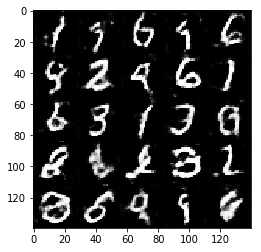

Epoch 1/2... Discriminator Loss: 1.1583... Generator Loss: 0.6587
Epoch 1/2... Discriminator Loss: 0.8933... Generator Loss: 0.8821
Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 0.7125
Epoch 1/2... Discriminator Loss: 1.0804... Generator Loss: 0.8746
Epoch 1/2... Discriminator Loss: 0.9932... Generator Loss: 0.9108
Epoch 1/2... Discriminator Loss: 1.5165... Generator Loss: 0.3523
Epoch 1/2... Discriminator Loss: 0.8096... Generator Loss: 1.0128
Epoch 2/2... Discriminator Loss: 0.9385... Generator Loss: 0.9856
Epoch 2/2... Discriminator Loss: 0.8488... Generator Loss: 1.1193
Epoch 2/2... Discriminator Loss: 0.9060... Generator Loss: 1.1751


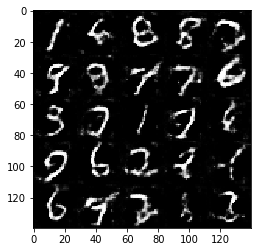

Epoch 2/2... Discriminator Loss: 0.9838... Generator Loss: 0.9874
Epoch 2/2... Discriminator Loss: 1.1644... Generator Loss: 0.5643
Epoch 2/2... Discriminator Loss: 0.9672... Generator Loss: 0.8889
Epoch 2/2... Discriminator Loss: 1.1168... Generator Loss: 0.6701
Epoch 2/2... Discriminator Loss: 0.8886... Generator Loss: 1.0809
Epoch 2/2... Discriminator Loss: 0.9691... Generator Loss: 0.9765
Epoch 2/2... Discriminator Loss: 1.1825... Generator Loss: 0.6013
Epoch 2/2... Discriminator Loss: 1.3632... Generator Loss: 0.5095
Epoch 2/2... Discriminator Loss: 0.6623... Generator Loss: 1.3316
Epoch 2/2... Discriminator Loss: 0.9776... Generator Loss: 0.7881


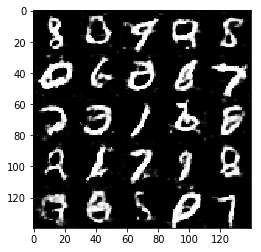

Epoch 2/2... Discriminator Loss: 1.0838... Generator Loss: 0.6911
Epoch 2/2... Discriminator Loss: 0.9065... Generator Loss: 1.1868
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 0.5442
Epoch 2/2... Discriminator Loss: 0.6892... Generator Loss: 1.4388
Epoch 2/2... Discriminator Loss: 0.8500... Generator Loss: 1.0736
Epoch 2/2... Discriminator Loss: 0.8752... Generator Loss: 0.9355
Epoch 2/2... Discriminator Loss: 0.9885... Generator Loss: 0.7477
Epoch 2/2... Discriminator Loss: 1.1006... Generator Loss: 0.8206
Epoch 2/2... Discriminator Loss: 1.1371... Generator Loss: 0.6169
Epoch 2/2... Discriminator Loss: 0.8222... Generator Loss: 1.2804


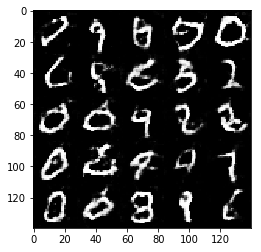

Epoch 2/2... Discriminator Loss: 1.0327... Generator Loss: 0.9263
Epoch 2/2... Discriminator Loss: 0.9185... Generator Loss: 0.9167
Epoch 2/2... Discriminator Loss: 0.9995... Generator Loss: 1.2608
Epoch 2/2... Discriminator Loss: 1.2084... Generator Loss: 1.7415
Epoch 2/2... Discriminator Loss: 1.3213... Generator Loss: 0.4584
Epoch 2/2... Discriminator Loss: 1.1023... Generator Loss: 0.6366
Epoch 2/2... Discriminator Loss: 1.1480... Generator Loss: 0.7021
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 0.5079
Epoch 2/2... Discriminator Loss: 0.7920... Generator Loss: 1.0321
Epoch 2/2... Discriminator Loss: 1.0732... Generator Loss: 1.1331


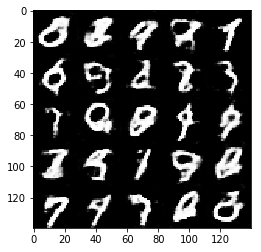

Epoch 2/2... Discriminator Loss: 1.0171... Generator Loss: 1.1249
Epoch 2/2... Discriminator Loss: 0.7051... Generator Loss: 1.1908
Epoch 2/2... Discriminator Loss: 1.2120... Generator Loss: 0.7920
Epoch 2/2... Discriminator Loss: 0.6891... Generator Loss: 1.1197
Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 0.7834
Epoch 2/2... Discriminator Loss: 0.7617... Generator Loss: 0.9952
Epoch 2/2... Discriminator Loss: 1.7072... Generator Loss: 1.7210
Epoch 2/2... Discriminator Loss: 1.0859... Generator Loss: 0.5933
Epoch 2/2... Discriminator Loss: 1.4655... Generator Loss: 0.4302
Epoch 2/2... Discriminator Loss: 0.7879... Generator Loss: 1.2881


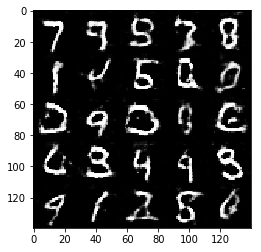

Epoch 2/2... Discriminator Loss: 0.8885... Generator Loss: 1.0823
Epoch 2/2... Discriminator Loss: 1.2069... Generator Loss: 0.5610
Epoch 2/2... Discriminator Loss: 0.9094... Generator Loss: 1.3957
Epoch 2/2... Discriminator Loss: 1.0576... Generator Loss: 0.7273
Epoch 2/2... Discriminator Loss: 0.7773... Generator Loss: 0.9737
Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 1.0097
Epoch 2/2... Discriminator Loss: 0.9029... Generator Loss: 0.7197
Epoch 2/2... Discriminator Loss: 0.9358... Generator Loss: 0.9839
Epoch 2/2... Discriminator Loss: 0.9695... Generator Loss: 0.7601
Epoch 2/2... Discriminator Loss: 1.1676... Generator Loss: 0.6068


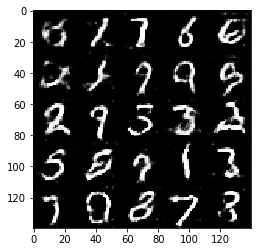

Epoch 2/2... Discriminator Loss: 0.8368... Generator Loss: 1.3208
Epoch 2/2... Discriminator Loss: 0.7976... Generator Loss: 1.2791
Epoch 2/2... Discriminator Loss: 1.1356... Generator Loss: 0.5769
Epoch 2/2... Discriminator Loss: 0.9182... Generator Loss: 1.2848
Epoch 2/2... Discriminator Loss: 1.0571... Generator Loss: 0.5845
Epoch 2/2... Discriminator Loss: 0.9304... Generator Loss: 0.9484
Epoch 2/2... Discriminator Loss: 1.2156... Generator Loss: 0.6979
Epoch 2/2... Discriminator Loss: 0.9900... Generator Loss: 0.8833
Epoch 2/2... Discriminator Loss: 0.9420... Generator Loss: 0.8260
Epoch 2/2... Discriminator Loss: 1.6408... Generator Loss: 0.2849


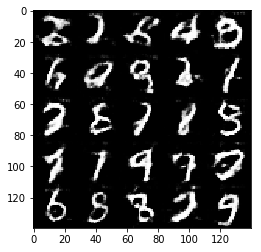

Epoch 2/2... Discriminator Loss: 1.1541... Generator Loss: 0.7802
Epoch 2/2... Discriminator Loss: 0.7284... Generator Loss: 0.9848
Epoch 2/2... Discriminator Loss: 0.9812... Generator Loss: 0.7577
Epoch 2/2... Discriminator Loss: 1.1563... Generator Loss: 1.3803
Epoch 2/2... Discriminator Loss: 1.0078... Generator Loss: 0.6778
Epoch 2/2... Discriminator Loss: 0.9180... Generator Loss: 1.0324
Epoch 2/2... Discriminator Loss: 0.7711... Generator Loss: 0.9624
Epoch 2/2... Discriminator Loss: 0.9592... Generator Loss: 1.0311
Epoch 2/2... Discriminator Loss: 0.8046... Generator Loss: 1.4326
Epoch 2/2... Discriminator Loss: 1.0830... Generator Loss: 0.5611


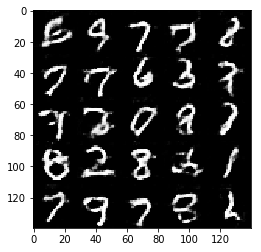

Epoch 2/2... Discriminator Loss: 1.5268... Generator Loss: 0.3334
Epoch 2/2... Discriminator Loss: 0.9213... Generator Loss: 0.8392
Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 0.6465
Epoch 2/2... Discriminator Loss: 1.7677... Generator Loss: 0.2522
Epoch 2/2... Discriminator Loss: 1.5385... Generator Loss: 0.3025
Epoch 2/2... Discriminator Loss: 0.7101... Generator Loss: 1.5106
Epoch 2/2... Discriminator Loss: 0.8214... Generator Loss: 0.8939
Epoch 2/2... Discriminator Loss: 0.5483... Generator Loss: 1.5277
Epoch 2/2... Discriminator Loss: 1.0120... Generator Loss: 0.6027
Epoch 2/2... Discriminator Loss: 1.0713... Generator Loss: 0.8098


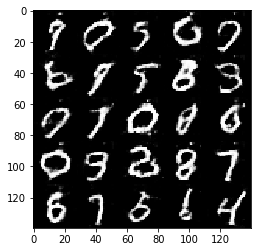

Epoch 2/2... Discriminator Loss: 0.7788... Generator Loss: 0.9772
Epoch 2/2... Discriminator Loss: 1.2103... Generator Loss: 0.5204
Epoch 2/2... Discriminator Loss: 1.3055... Generator Loss: 0.4276
Epoch 2/2... Discriminator Loss: 0.7798... Generator Loss: 1.0698
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 0.6564
Epoch 2/2... Discriminator Loss: 1.1602... Generator Loss: 0.5047
Epoch 2/2... Discriminator Loss: 0.8340... Generator Loss: 1.2986
Epoch 2/2... Discriminator Loss: 0.8258... Generator Loss: 1.5544
Epoch 2/2... Discriminator Loss: 1.2284... Generator Loss: 0.7576
Epoch 2/2... Discriminator Loss: 1.5140... Generator Loss: 0.3766


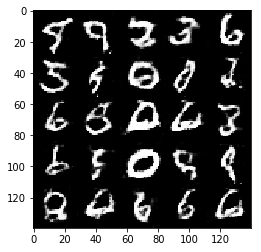

Epoch 2/2... Discriminator Loss: 1.1276... Generator Loss: 1.6921
Epoch 2/2... Discriminator Loss: 1.2616... Generator Loss: 0.9581
Epoch 2/2... Discriminator Loss: 0.9067... Generator Loss: 0.7520
Epoch 2/2... Discriminator Loss: 1.1297... Generator Loss: 0.5186
Epoch 2/2... Discriminator Loss: 1.6258... Generator Loss: 0.2982
Epoch 2/2... Discriminator Loss: 1.2426... Generator Loss: 1.3558
Epoch 2/2... Discriminator Loss: 0.8732... Generator Loss: 1.1171
Epoch 2/2... Discriminator Loss: 0.9354... Generator Loss: 0.7320
Epoch 2/2... Discriminator Loss: 0.9955... Generator Loss: 0.9602
Epoch 2/2... Discriminator Loss: 1.0288... Generator Loss: 1.4547


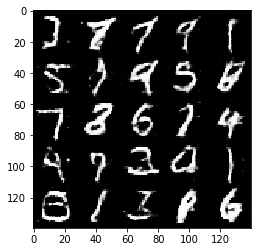

Epoch 2/2... Discriminator Loss: 0.7185... Generator Loss: 1.1534
Epoch 2/2... Discriminator Loss: 0.9095... Generator Loss: 0.9594
Epoch 2/2... Discriminator Loss: 0.7651... Generator Loss: 1.4588
Epoch 2/2... Discriminator Loss: 0.8454... Generator Loss: 0.9214
Epoch 2/2... Discriminator Loss: 0.8101... Generator Loss: 0.9668
Epoch 2/2... Discriminator Loss: 1.1703... Generator Loss: 0.5279
Epoch 2/2... Discriminator Loss: 1.0074... Generator Loss: 0.9238
Epoch 2/2... Discriminator Loss: 1.2796... Generator Loss: 0.4646
Epoch 2/2... Discriminator Loss: 0.8779... Generator Loss: 1.1535
Epoch 2/2... Discriminator Loss: 0.8993... Generator Loss: 1.1658


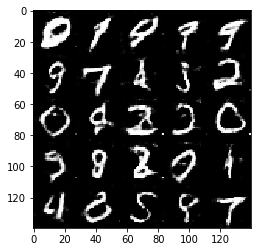

Epoch 2/2... Discriminator Loss: 0.9676... Generator Loss: 0.8568
Epoch 2/2... Discriminator Loss: 0.9691... Generator Loss: 0.9401
Epoch 2/2... Discriminator Loss: 0.8984... Generator Loss: 0.7955
Epoch 2/2... Discriminator Loss: 0.9835... Generator Loss: 0.6973
Epoch 2/2... Discriminator Loss: 1.2492... Generator Loss: 0.4370
Epoch 2/2... Discriminator Loss: 0.6346... Generator Loss: 1.3605
Epoch 2/2... Discriminator Loss: 1.0233... Generator Loss: 0.5682
Epoch 2/2... Discriminator Loss: 0.7170... Generator Loss: 1.2153
Epoch 2/2... Discriminator Loss: 1.8193... Generator Loss: 0.2259
Epoch 2/2... Discriminator Loss: 1.2578... Generator Loss: 0.5002


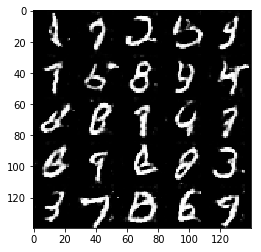

Epoch 2/2... Discriminator Loss: 0.9915... Generator Loss: 1.2745
Epoch 2/2... Discriminator Loss: 0.9824... Generator Loss: 0.7896
Epoch 2/2... Discriminator Loss: 1.2346... Generator Loss: 0.6797
Epoch 2/2... Discriminator Loss: 1.2055... Generator Loss: 0.4763
Epoch 2/2... Discriminator Loss: 0.9075... Generator Loss: 0.8492
Epoch 2/2... Discriminator Loss: 2.6771... Generator Loss: 0.0985
Epoch 2/2... Discriminator Loss: 0.8234... Generator Loss: 0.8943
Epoch 2/2... Discriminator Loss: 0.9388... Generator Loss: 0.7588
Epoch 2/2... Discriminator Loss: 1.0232... Generator Loss: 0.6405
Epoch 2/2... Discriminator Loss: 0.9499... Generator Loss: 1.0768


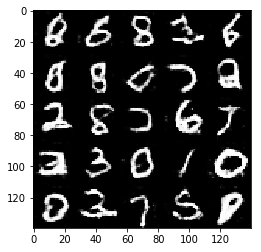

Epoch 2/2... Discriminator Loss: 1.2629... Generator Loss: 0.4880
Epoch 2/2... Discriminator Loss: 1.0112... Generator Loss: 0.8262
Epoch 2/2... Discriminator Loss: 1.1260... Generator Loss: 0.9204
Epoch 2/2... Discriminator Loss: 0.8986... Generator Loss: 1.2051
Epoch 2/2... Discriminator Loss: 0.9359... Generator Loss: 0.7433
Epoch 2/2... Discriminator Loss: 1.0701... Generator Loss: 0.6277
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 0.3954
Epoch 2/2... Discriminator Loss: 0.9014... Generator Loss: 0.8282
Epoch 2/2... Discriminator Loss: 1.3538... Generator Loss: 0.3900
Epoch 2/2... Discriminator Loss: 1.1047... Generator Loss: 0.5977


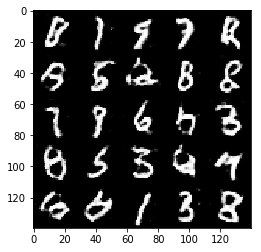

Epoch 2/2... Discriminator Loss: 0.8778... Generator Loss: 0.8164
Epoch 2/2... Discriminator Loss: 0.7132... Generator Loss: 1.3868
Epoch 2/2... Discriminator Loss: 1.0220... Generator Loss: 0.9898
Epoch 2/2... Discriminator Loss: 0.9082... Generator Loss: 0.7815
Epoch 2/2... Discriminator Loss: 1.0203... Generator Loss: 0.7246
Epoch 2/2... Discriminator Loss: 0.5806... Generator Loss: 1.5238
Epoch 2/2... Discriminator Loss: 1.4122... Generator Loss: 0.3791
Epoch 2/2... Discriminator Loss: 0.8037... Generator Loss: 1.0121
Epoch 2/2... Discriminator Loss: 0.7881... Generator Loss: 1.1538
Epoch 2/2... Discriminator Loss: 1.2012... Generator Loss: 0.4898


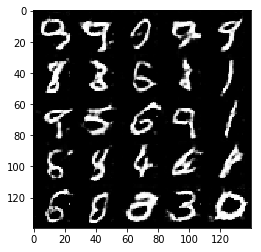

Epoch 2/2... Discriminator Loss: 1.0486... Generator Loss: 1.2383
Epoch 2/2... Discriminator Loss: 0.7426... Generator Loss: 1.3698
Epoch 2/2... Discriminator Loss: 1.4119... Generator Loss: 0.3972
Epoch 2/2... Discriminator Loss: 0.8799... Generator Loss: 0.9533
Epoch 2/2... Discriminator Loss: 1.5969... Generator Loss: 0.3387
Epoch 2/2... Discriminator Loss: 1.1234... Generator Loss: 1.7676
Epoch 2/2... Discriminator Loss: 0.7320... Generator Loss: 1.5028
Epoch 2/2... Discriminator Loss: 1.1470... Generator Loss: 0.5852
Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 1.4919
Epoch 2/2... Discriminator Loss: 1.0227... Generator Loss: 1.7849


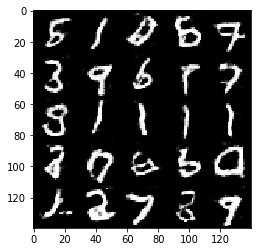

Epoch 2/2... Discriminator Loss: 0.8004... Generator Loss: 1.4625
Epoch 2/2... Discriminator Loss: 0.8387... Generator Loss: 0.8038
Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 0.7093
Epoch 2/2... Discriminator Loss: 0.6979... Generator Loss: 1.2157
Epoch 2/2... Discriminator Loss: 0.7543... Generator Loss: 1.2369
Epoch 2/2... Discriminator Loss: 0.7798... Generator Loss: 1.0012
Epoch 2/2... Discriminator Loss: 1.2822... Generator Loss: 0.4418
Epoch 2/2... Discriminator Loss: 0.8077... Generator Loss: 0.9748
Epoch 2/2... Discriminator Loss: 1.5441... Generator Loss: 0.3356
Epoch 2/2... Discriminator Loss: 1.3420... Generator Loss: 1.0531


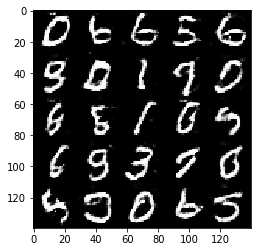

Epoch 2/2... Discriminator Loss: 0.8523... Generator Loss: 1.1816
Epoch 2/2... Discriminator Loss: 0.9897... Generator Loss: 0.7986
Epoch 2/2... Discriminator Loss: 0.8546... Generator Loss: 1.3860
Epoch 2/2... Discriminator Loss: 1.1113... Generator Loss: 0.5817
Epoch 2/2... Discriminator Loss: 0.4616... Generator Loss: 1.2940
Epoch 2/2... Discriminator Loss: 1.7211... Generator Loss: 0.3264
Epoch 2/2... Discriminator Loss: 0.9243... Generator Loss: 0.8430
Epoch 2/2... Discriminator Loss: 1.0156... Generator Loss: 0.7122
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.3720
Epoch 2/2... Discriminator Loss: 0.9026... Generator Loss: 1.1036


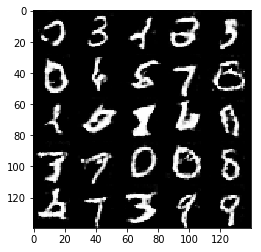

Epoch 2/2... Discriminator Loss: 0.7227... Generator Loss: 1.2725
Epoch 2/2... Discriminator Loss: 0.9098... Generator Loss: 0.8812
Epoch 2/2... Discriminator Loss: 0.7367... Generator Loss: 1.1144
Epoch 2/2... Discriminator Loss: 0.8650... Generator Loss: 1.0543
Epoch 2/2... Discriminator Loss: 0.8585... Generator Loss: 0.9924


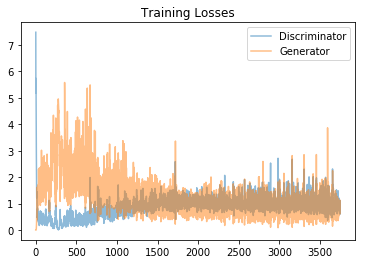

In [24]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

0.0003
0.5
Epoch 1/1... Discriminator Loss: 4.3503... Generator Loss: 0.0230
Epoch 1/1... Discriminator Loss: 1.6855... Generator Loss: 0.4872
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 0.6480... Generator Loss: 1.3894
Epoch 1/1... Discriminator Loss: 0.5650... Generator Loss: 1.4335
Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 1.4097
Epoch 1/1... Discriminator Loss: 0.4530... Generator Loss: 1.5077
Epoch 1/1... Discriminator Loss: 0.2609... Generator Loss: 2.0266
Epoch 1/1... Discriminator Loss: 0.4305... Generator Loss: 1.6896
Epoch 1/1... Discriminator Loss: 0.7047... Generator Loss: 1.3563


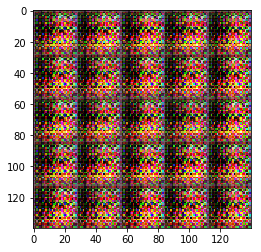

Epoch 1/1... Discriminator Loss: 0.5650... Generator Loss: 1.5906
Epoch 1/1... Discriminator Loss: 0.4915... Generator Loss: 1.7307
Epoch 1/1... Discriminator Loss: 0.2738... Generator Loss: 2.0469
Epoch 1/1... Discriminator Loss: 0.5215... Generator Loss: 1.5159
Epoch 1/1... Discriminator Loss: 0.3098... Generator Loss: 1.8939
Epoch 1/1... Discriminator Loss: 0.3553... Generator Loss: 1.8760
Epoch 1/1... Discriminator Loss: 0.2349... Generator Loss: 2.2732
Epoch 1/1... Discriminator Loss: 0.1032... Generator Loss: 3.1047
Epoch 1/1... Discriminator Loss: 0.1113... Generator Loss: 2.9023
Epoch 1/1... Discriminator Loss: 0.2710... Generator Loss: 2.1194


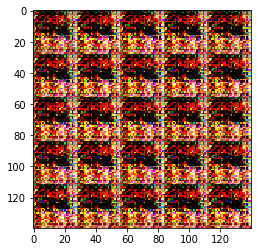

Epoch 1/1... Discriminator Loss: 0.1460... Generator Loss: 2.4419
Epoch 1/1... Discriminator Loss: 0.6316... Generator Loss: 5.4831
Epoch 1/1... Discriminator Loss: 0.1633... Generator Loss: 3.4287
Epoch 1/1... Discriminator Loss: 0.1930... Generator Loss: 2.2362
Epoch 1/1... Discriminator Loss: 0.2460... Generator Loss: 2.0024
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 0.5261
Epoch 1/1... Discriminator Loss: 0.2636... Generator Loss: 2.6340
Epoch 1/1... Discriminator Loss: 0.2553... Generator Loss: 2.2880
Epoch 1/1... Discriminator Loss: 0.0715... Generator Loss: 2.9607
Epoch 1/1... Discriminator Loss: 0.1924... Generator Loss: 2.7273


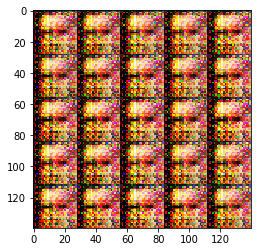

Epoch 1/1... Discriminator Loss: 0.1262... Generator Loss: 2.6289
Epoch 1/1... Discriminator Loss: 0.0523... Generator Loss: 3.4335
Epoch 1/1... Discriminator Loss: 0.1537... Generator Loss: 2.4954
Epoch 1/1... Discriminator Loss: 0.2063... Generator Loss: 2.3474
Epoch 1/1... Discriminator Loss: 0.1270... Generator Loss: 3.7609
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.4897
Epoch 1/1... Discriminator Loss: 0.4584... Generator Loss: 1.6931
Epoch 1/1... Discriminator Loss: 0.1519... Generator Loss: 2.8487
Epoch 1/1... Discriminator Loss: 0.5894... Generator Loss: 1.1058
Epoch 1/1... Discriminator Loss: 0.0647... Generator Loss: 3.1675


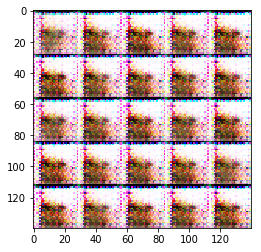

Epoch 1/1... Discriminator Loss: 0.1987... Generator Loss: 3.8968
Epoch 1/1... Discriminator Loss: 0.0208... Generator Loss: 5.9692
Epoch 1/1... Discriminator Loss: 0.6593... Generator Loss: 1.2874
Epoch 1/1... Discriminator Loss: 0.3142... Generator Loss: 2.0012
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 0.7334... Generator Loss: 1.4291
Epoch 1/1... Discriminator Loss: 2.4538... Generator Loss: 0.1519
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 1.4310
Epoch 1/1... Discriminator Loss: 0.2414... Generator Loss: 3.2642


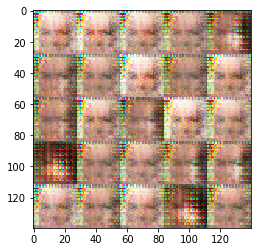

Epoch 1/1... Discriminator Loss: 0.4557... Generator Loss: 2.8433
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 2.0747
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 1.0565
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 1.1379
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 1.0585
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.7769


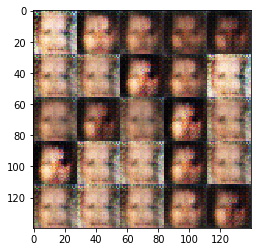

Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 1.0694
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.1792
Epoch 1/1... Discriminator Loss: 2.1579... Generator Loss: 0.4397
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 0.9089


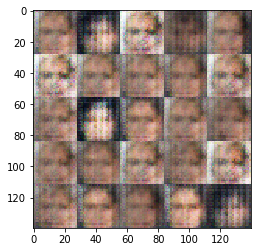

Epoch 1/1... Discriminator Loss: 1.6094... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.8800


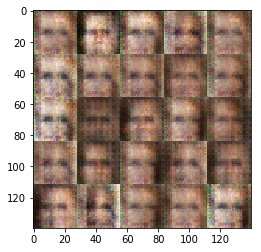

Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.9018


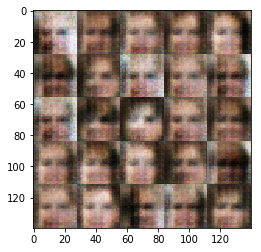

Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.5831... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.6003... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7354


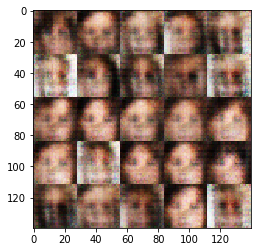

Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 0.9347
Epoch 1/1... Discriminator Loss: 1.7367... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.7184


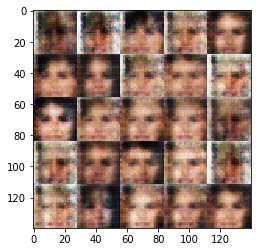

Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7265


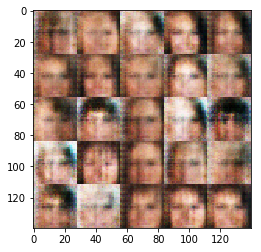

Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8094


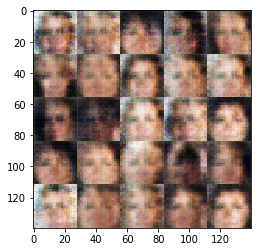

Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.9275
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.7534


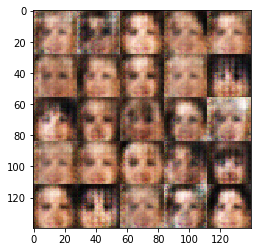

Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.8318


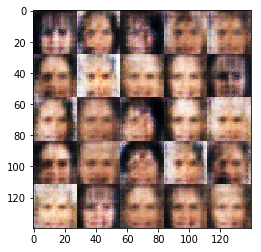

Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7821


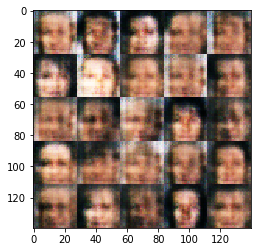

Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.7598


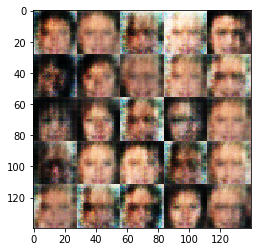

Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.5560... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.5356... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.9036


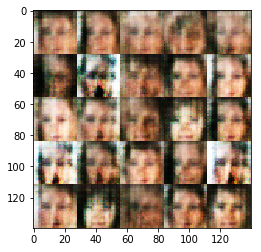

Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.6356... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.0212
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7288


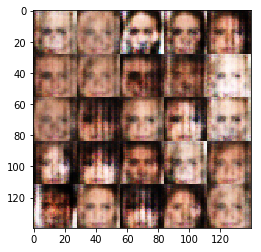

Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7733


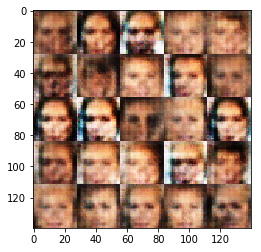

Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.7502


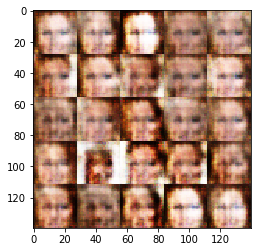

Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.6641


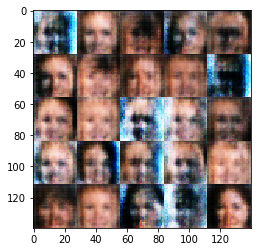

Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.8261


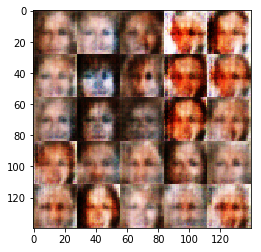

Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 0.8909


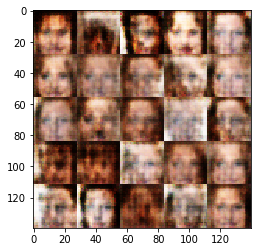

Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.6096... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.8954


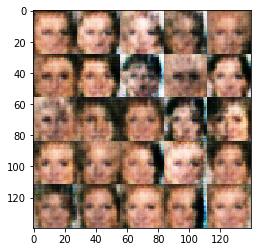

Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.8096


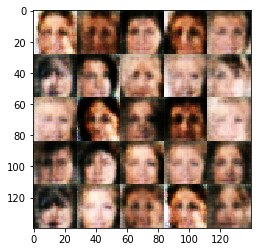

Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 1.0860
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 1.2083
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.8890... Generator Loss: 2.3921


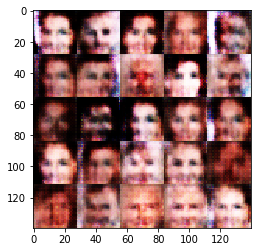

Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 1.5190
Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 0.9813... Generator Loss: 1.7140
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 1.3541
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 1.5087
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.8131... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.8433


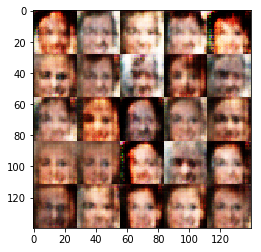

Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.8669... Generator Loss: 0.3112
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 1.1809
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 0.8161... Generator Loss: 1.3585


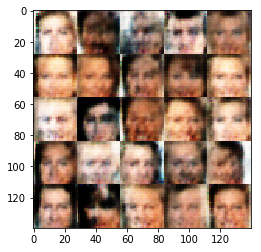

Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 0.6993... Generator Loss: 1.5778
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 1.7149
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 0.8147... Generator Loss: 0.9890


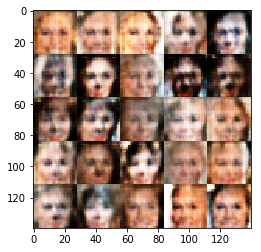

Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 1.1941
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 1.2449
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 1.3220
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 1.0875


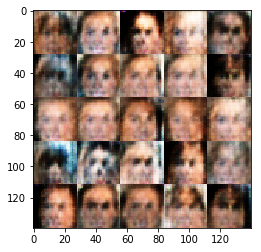

Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 1.8266
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 1.6442
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.5153
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 1.1645
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.5773


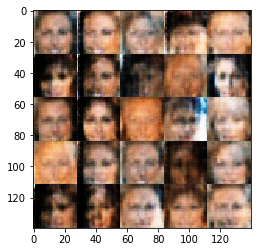

Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 1.2962
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 1.0621
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 1.3451
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.4925
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 0.9043


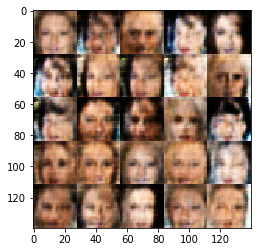

Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 1.1691
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 0.9188... Generator Loss: 1.3752
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 2.0082
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.6217
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.4730
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 1.3771
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 1.0762


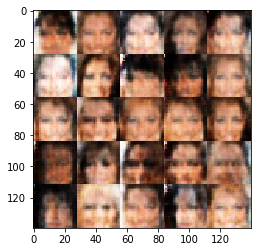

Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.5308... Generator Loss: 0.4463
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 1.1518
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.1149
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.7833


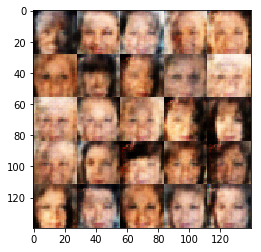

Epoch 1/1... Discriminator Loss: 1.5494... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.4772
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.5437
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.2805
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.7667


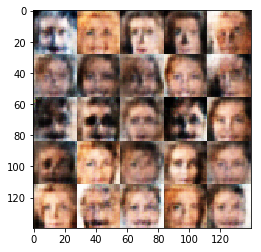

Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 1.5429
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 0.9352
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 1.6716
Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.9352


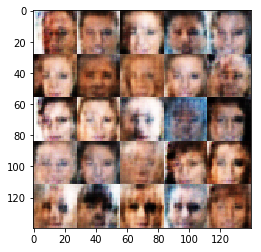

Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 1.3897
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 1.6825... Generator Loss: 0.3681
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.5281
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.7312


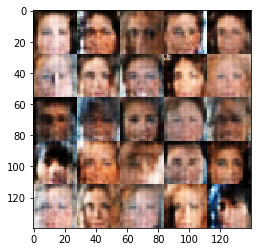

Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.2870
Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 1.0379
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 0.8402


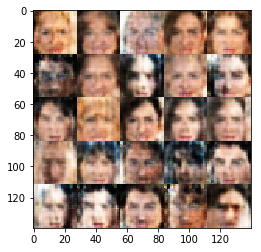

Epoch 1/1... Discriminator Loss: 1.6010... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.7673... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.5957... Generator Loss: 0.3492
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.7431... Generator Loss: 0.5251
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 0.8613


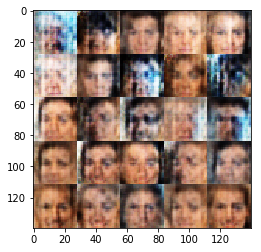

Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.7755


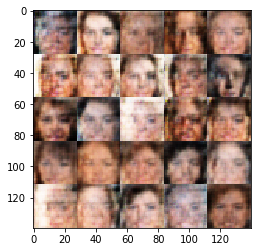

Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 1.1758
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.7361


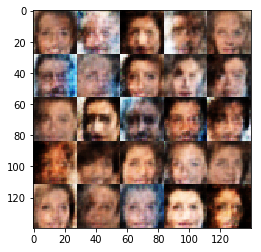

Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6838


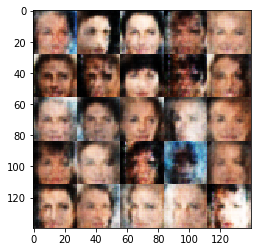

Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.7097


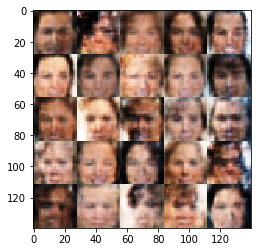

Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6980


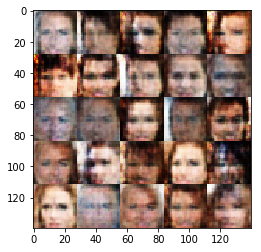

Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.8466


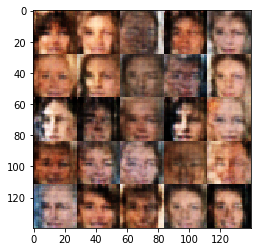

Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.7162


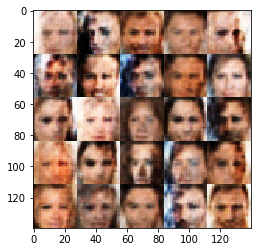

Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.6225


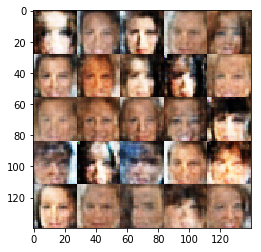

Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.8124


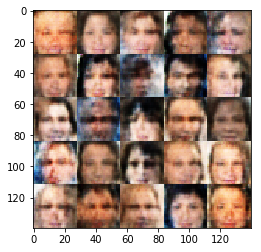

Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7387


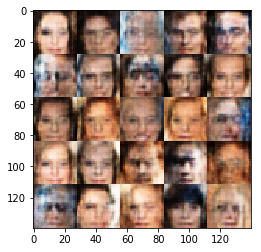

Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6855


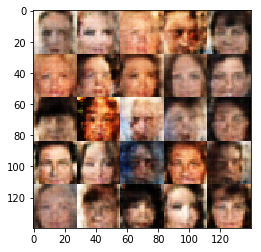

Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7250


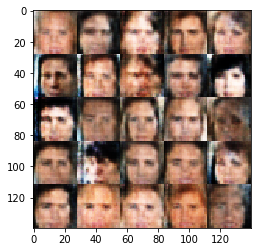

Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.8519


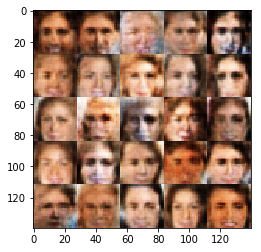

Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8255


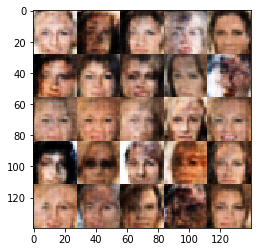

Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.7473


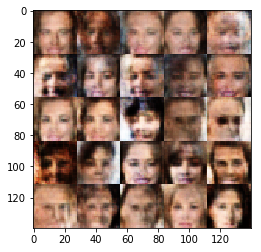

Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.7106


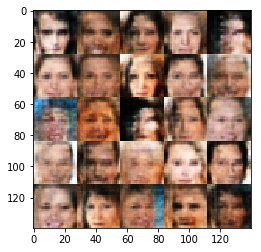

Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.5647
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.8207


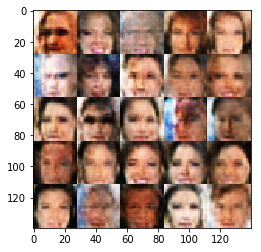

Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.7349


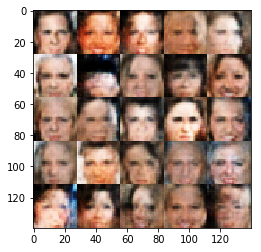

Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.7870


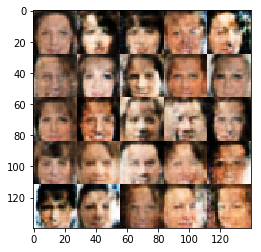

Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.5753


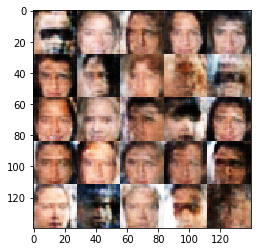

Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.7104


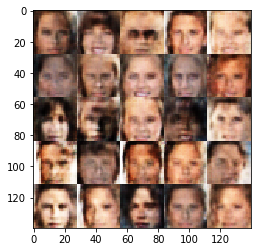

Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.7500


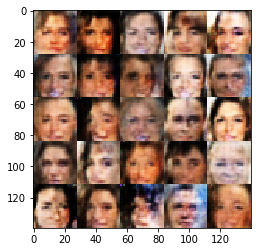

Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.7382


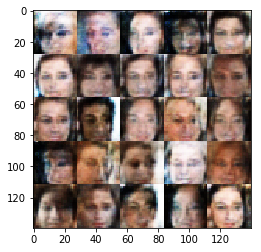

Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.7389


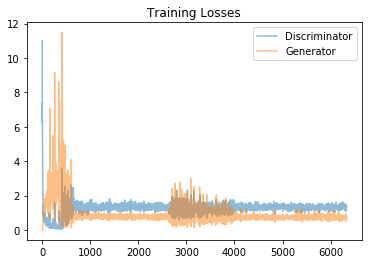

In [25]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

print(learning_rate)
print(beta1)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.